# Notebook Purpose
This notebook contains a handful of basic visualization about our datasette requests data. 

In [56]:
import pandas as pd

from usage_metrics.resources.sqlite import SQLiteManager

%config InlineBackend.figure_format = 'retina'

In [57]:
engine = SQLiteManager().get_engine()
print(engine)

with engine.connect() as con:
    logs = pd.read_sql_table("datasette_request_logs", con)

logs.info()

Engine(sqlite:////Users/apple/catalyst/business/usage_metrics/data/usage_metrics.db)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252892 entries, 0 to 252891
Data columns (total 45 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   insert_id                           252892 non-null  object        
 1   log_name                            252892 non-null  object        
 2   resource                            252892 non-null  object        
 3   text_payload                        300 non-null     object        
 4   timestamp                           252892 non-null  datetime64[ns]
 5   receive_timestamp                   252892 non-null  datetime64[ns]
 6   severity                            252892 non-null  object        
 7   http_request                        252892 non-null  object        
 8   labels                              252892 non-null  object        
 

## Internet Egress

### GB per month
This is pretty consistent with the "Cloud Run Network Internet Egress North America to North America" Google billing metric.

In [58]:
logs.set_index("timestamp").resample("1M").response_size.sum() / (10**9)

timestamp
2022-01-31      0.070885
2022-02-28     15.766535
2022-03-31    234.927183
2022-04-30    239.609769
2022-05-31     51.319176
Freq: M, Name: response_size, dtype: float64

### MBs requested per week

In [59]:
weekly_mb_sent = logs.set_index("timestamp").resample("1W").response_size.sum() / (10**6)

<AxesSubplot:xlabel='Week', ylabel='MB of Data Requested'>

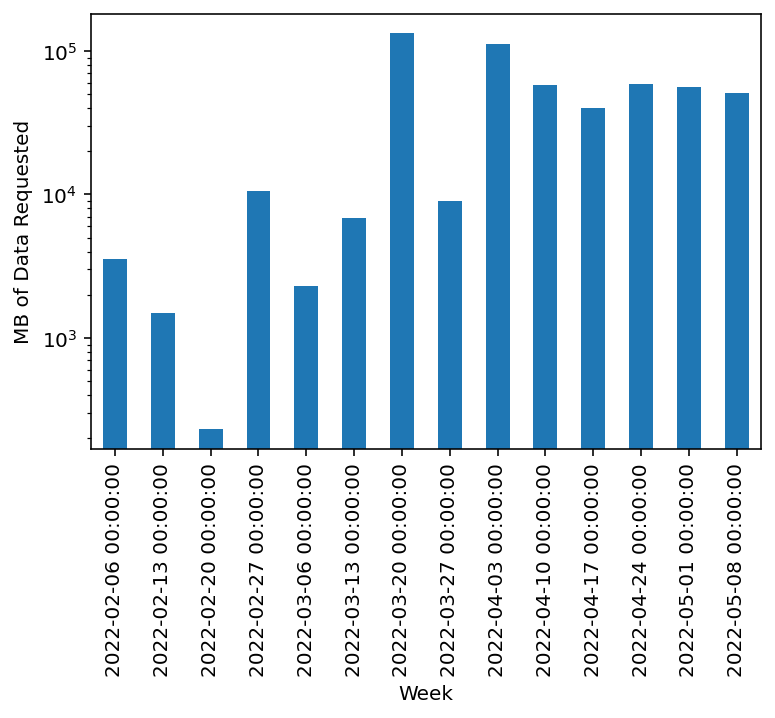

In [60]:
weekly_mb_sent.plot.bar(xlabel="Week", ylabel="MB of Data Requested", logy=True)

## Request Volume
Number of requests for ferc1 and pudl tables and downloads per week.

<AxesSubplot:xlabel='Week', ylabel='Number of Data Requests'>

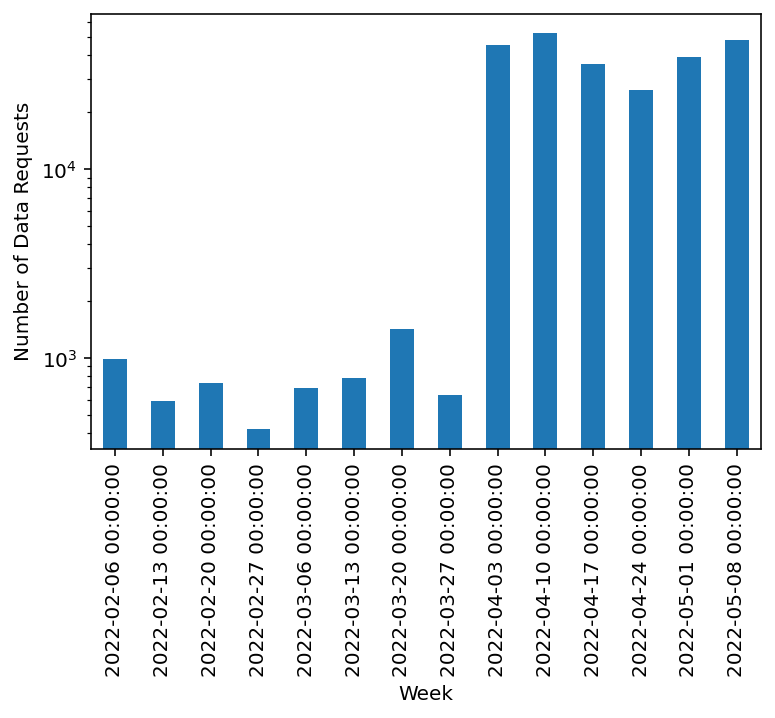

In [63]:
logs.set_index("timestamp").resample("1W").count().insert_id.plot.bar(xlabel="Week", ylabel="Number of Data Requests", logy=True)

## Top Data Requests
The top datasette path requests. This includes json, csv and db downloads.

### Number of top data requests

<AxesSubplot:title={'center':'Requests by Data Path'}, ylabel='Number of Requests'>

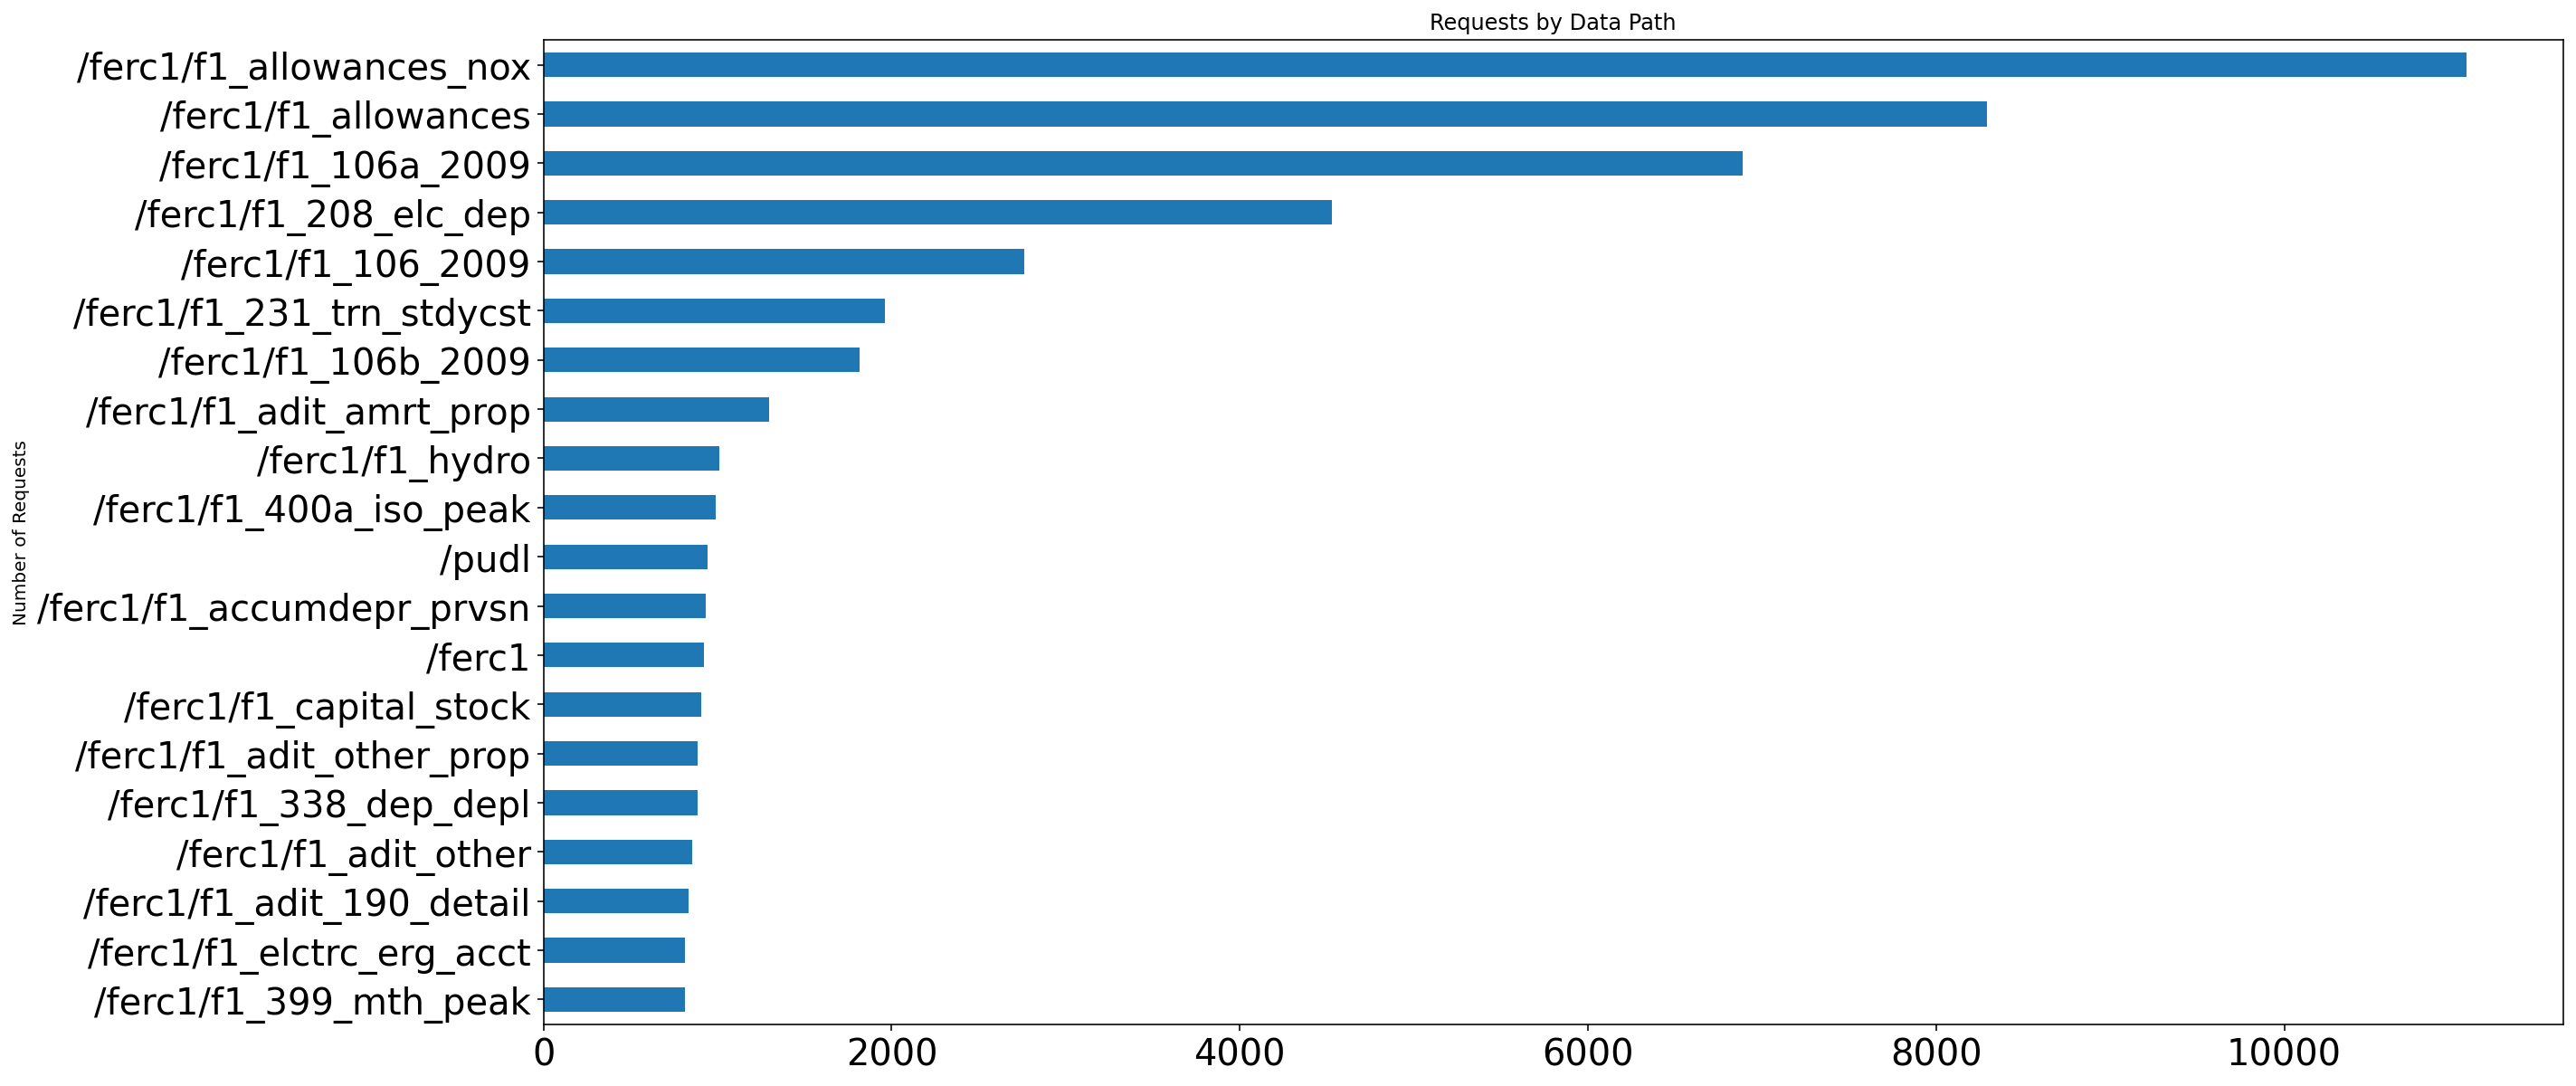

In [64]:
top_n = 20

logs.request_url_path.value_counts().head(top_n).sort_values().plot.barh(figsize=(20,10), fontsize=20, ylabel="Number of Requests", title="Requests by Data Path")

### Percent of all requests

This chart shows 19.523749268462428 % of all data requests.


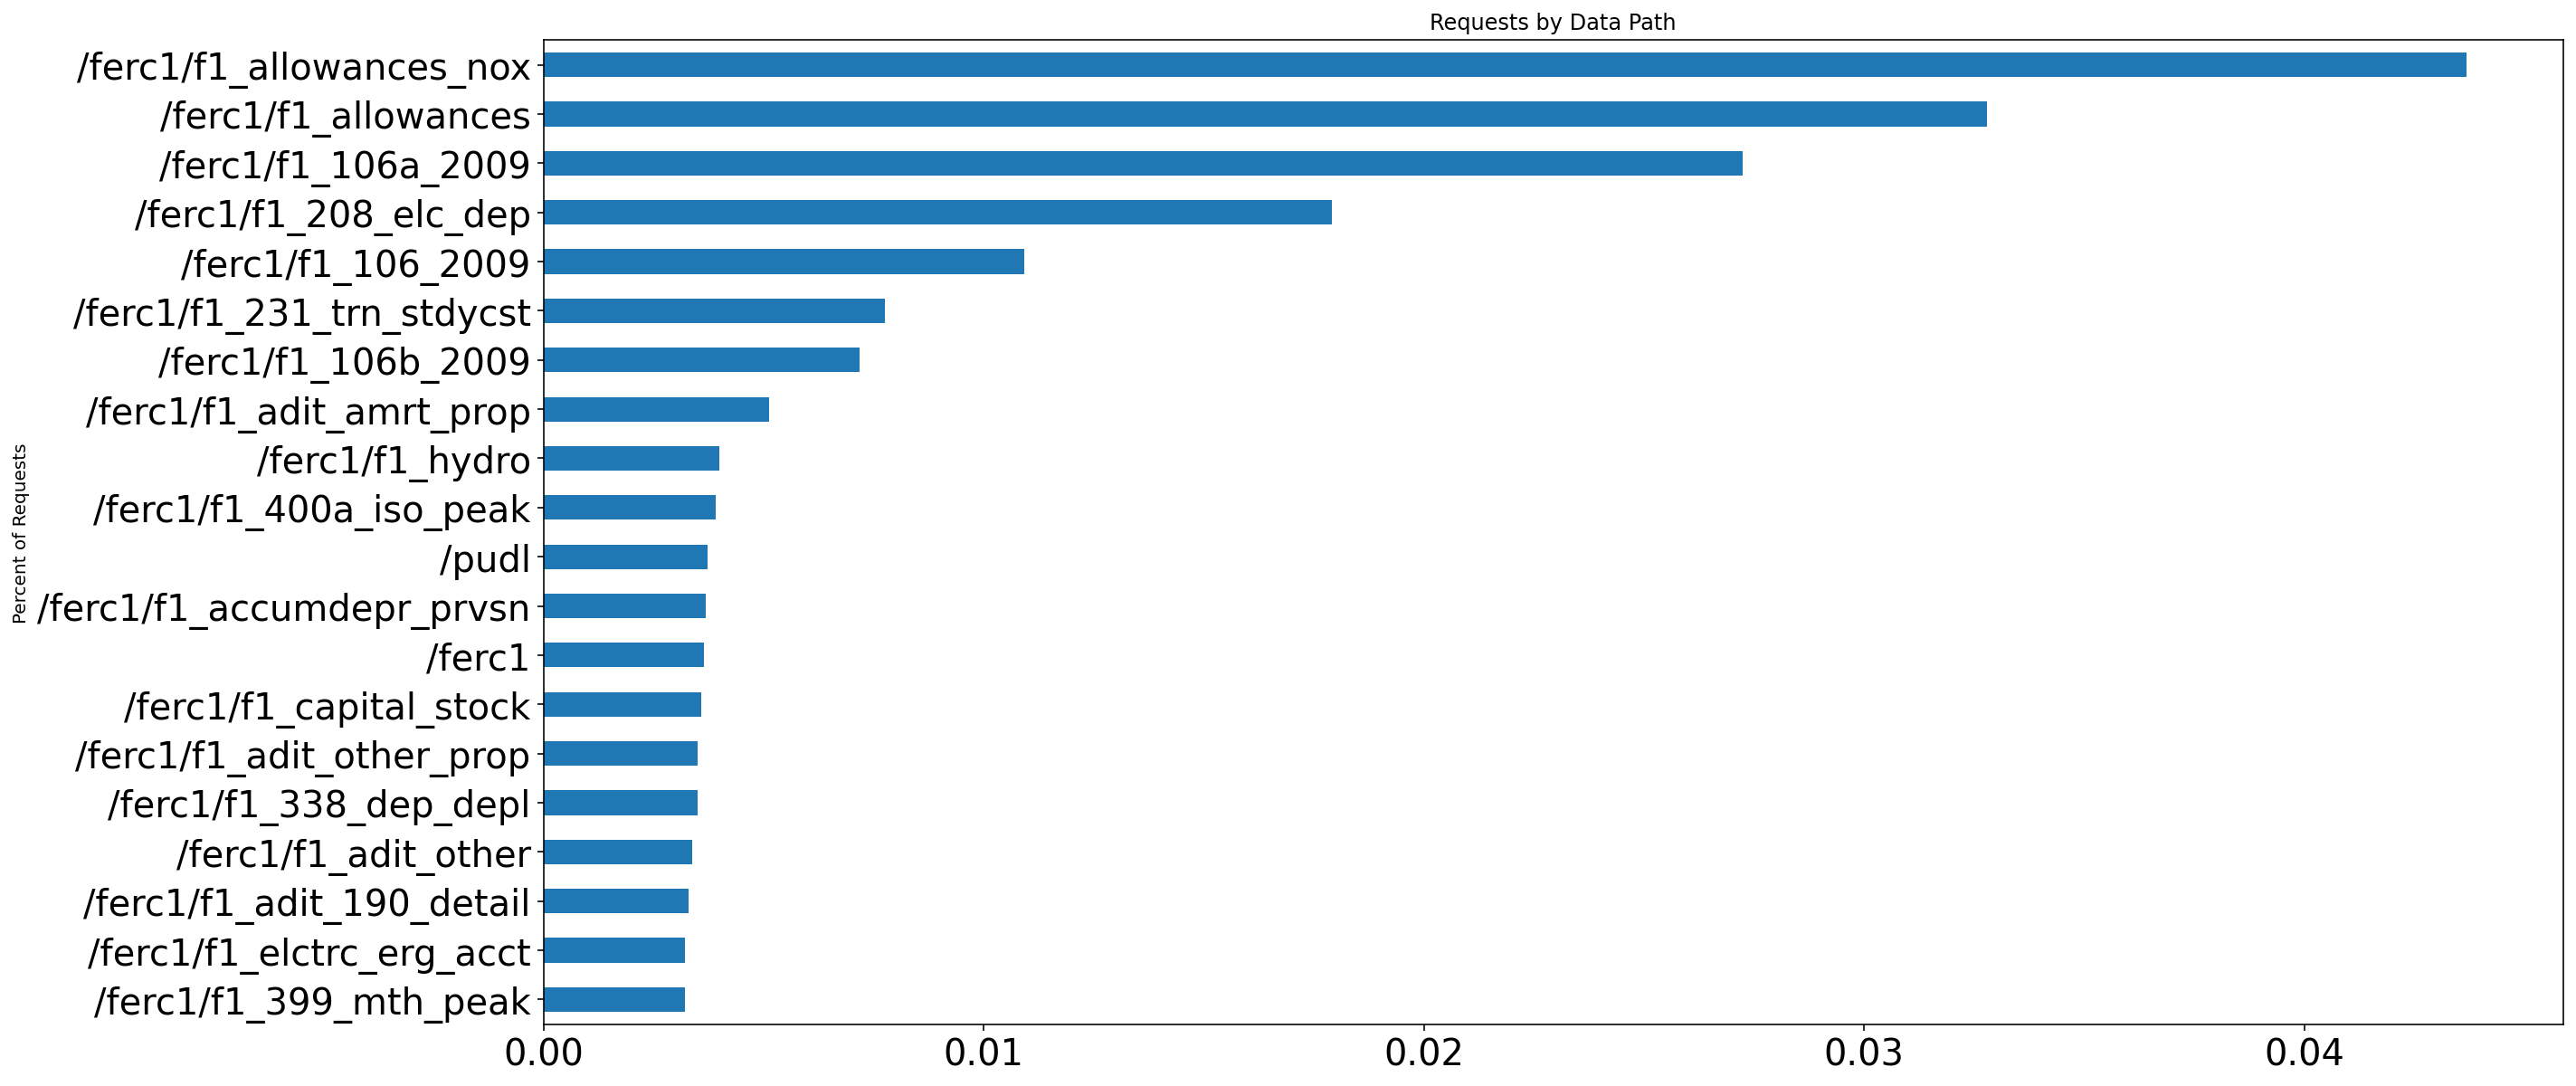

In [65]:
top_n = 20

top_paths = logs.request_url_path.value_counts(normalize=True).head(top_n)

top_paths.sort_values().plot.barh(figsize=(20,10), fontsize=20, ylabel="Percent of Requests", title="Requests by Data Path")

print(f"This chart shows {top_paths.sum() * 100} % of all data requests.")

## Top Organizations
Most organizations are generic internet providers however universities often have their own network set up. Unfortunately ipinfo charges for organization type so we have do some simple string filtering for now.  

### All orgs

In [66]:
logs.remote_ip_org.value_counts().head(10)

Hetzner Online GmbH                                              228033
Bezeq International-Ltd                                           11939
Oracle Corporation                                                 2675
Comcast Cable Communications, LLC                                  1086
Vodafone GmbH                                                      1069
IPXO UK LIMITED                                                     965
Microsoft Corporation                                               792
Charter Communications Inc                                          579
Southern New England Telephone Company and SNET America, Inc.       578
Sonic Telecom LLC                                                   464
Name: remote_ip_org, dtype: int64

### Academic Institutions

<AxesSubplot:title={'center':'Requests by Academic Organization'}, ylabel='Number of Requests'>

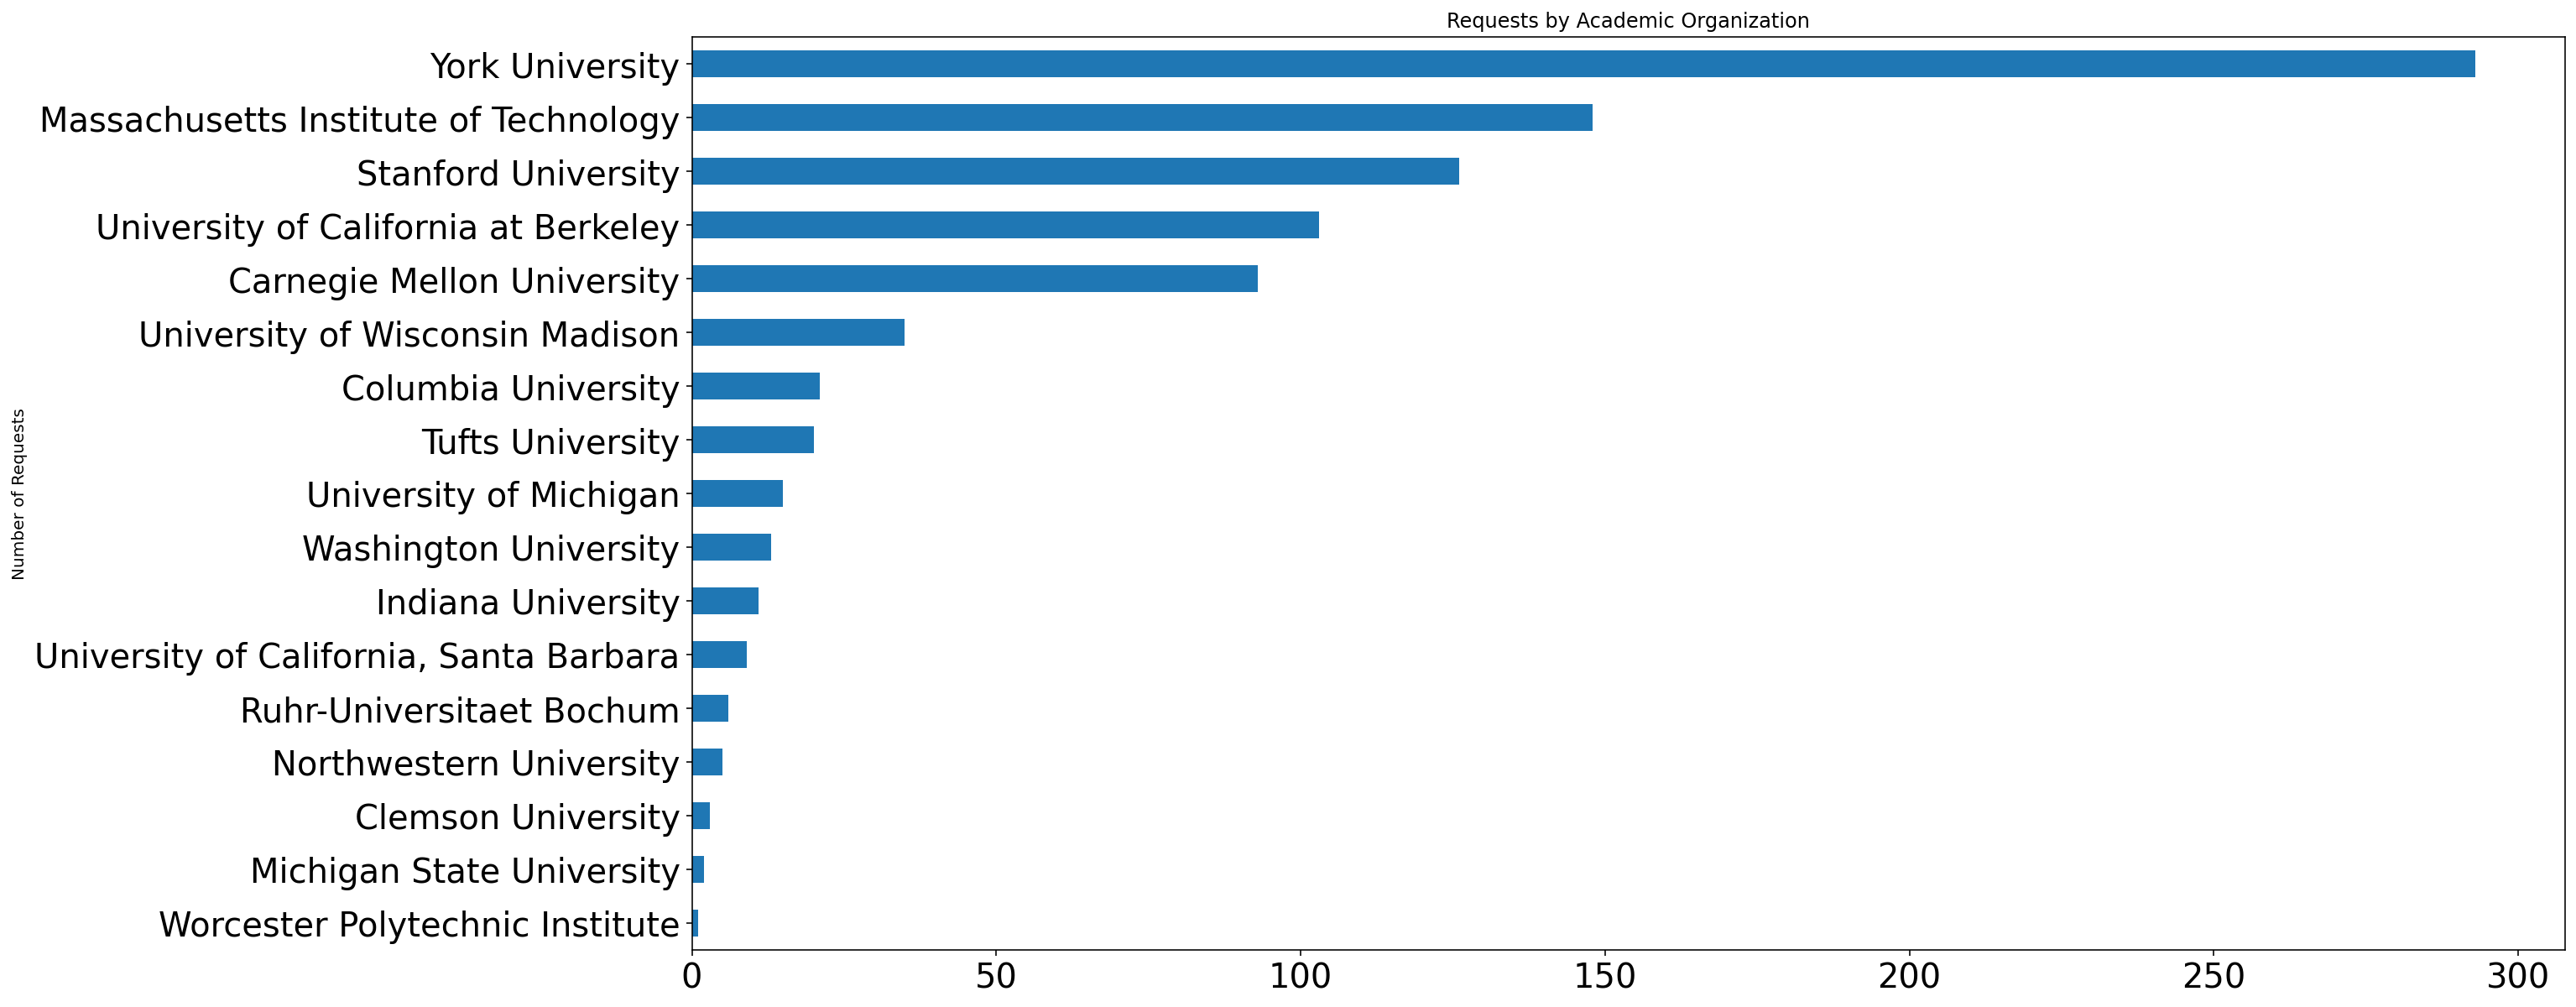

In [67]:
university_substrings = ["Universitaet", "University", "College", "Institute"]

is_uni = logs.remote_ip_org.str.contains("|".join(university_substrings))

logs[is_uni].remote_ip_org.value_counts().sort_values().plot.barh(figsize=(20,10), fontsize=20, ylabel="Number of Requests", title="Requests by Academic Organization")

## Top Cities

<AxesSubplot:title={'center':'Requests by City'}, ylabel='Number of Requests'>

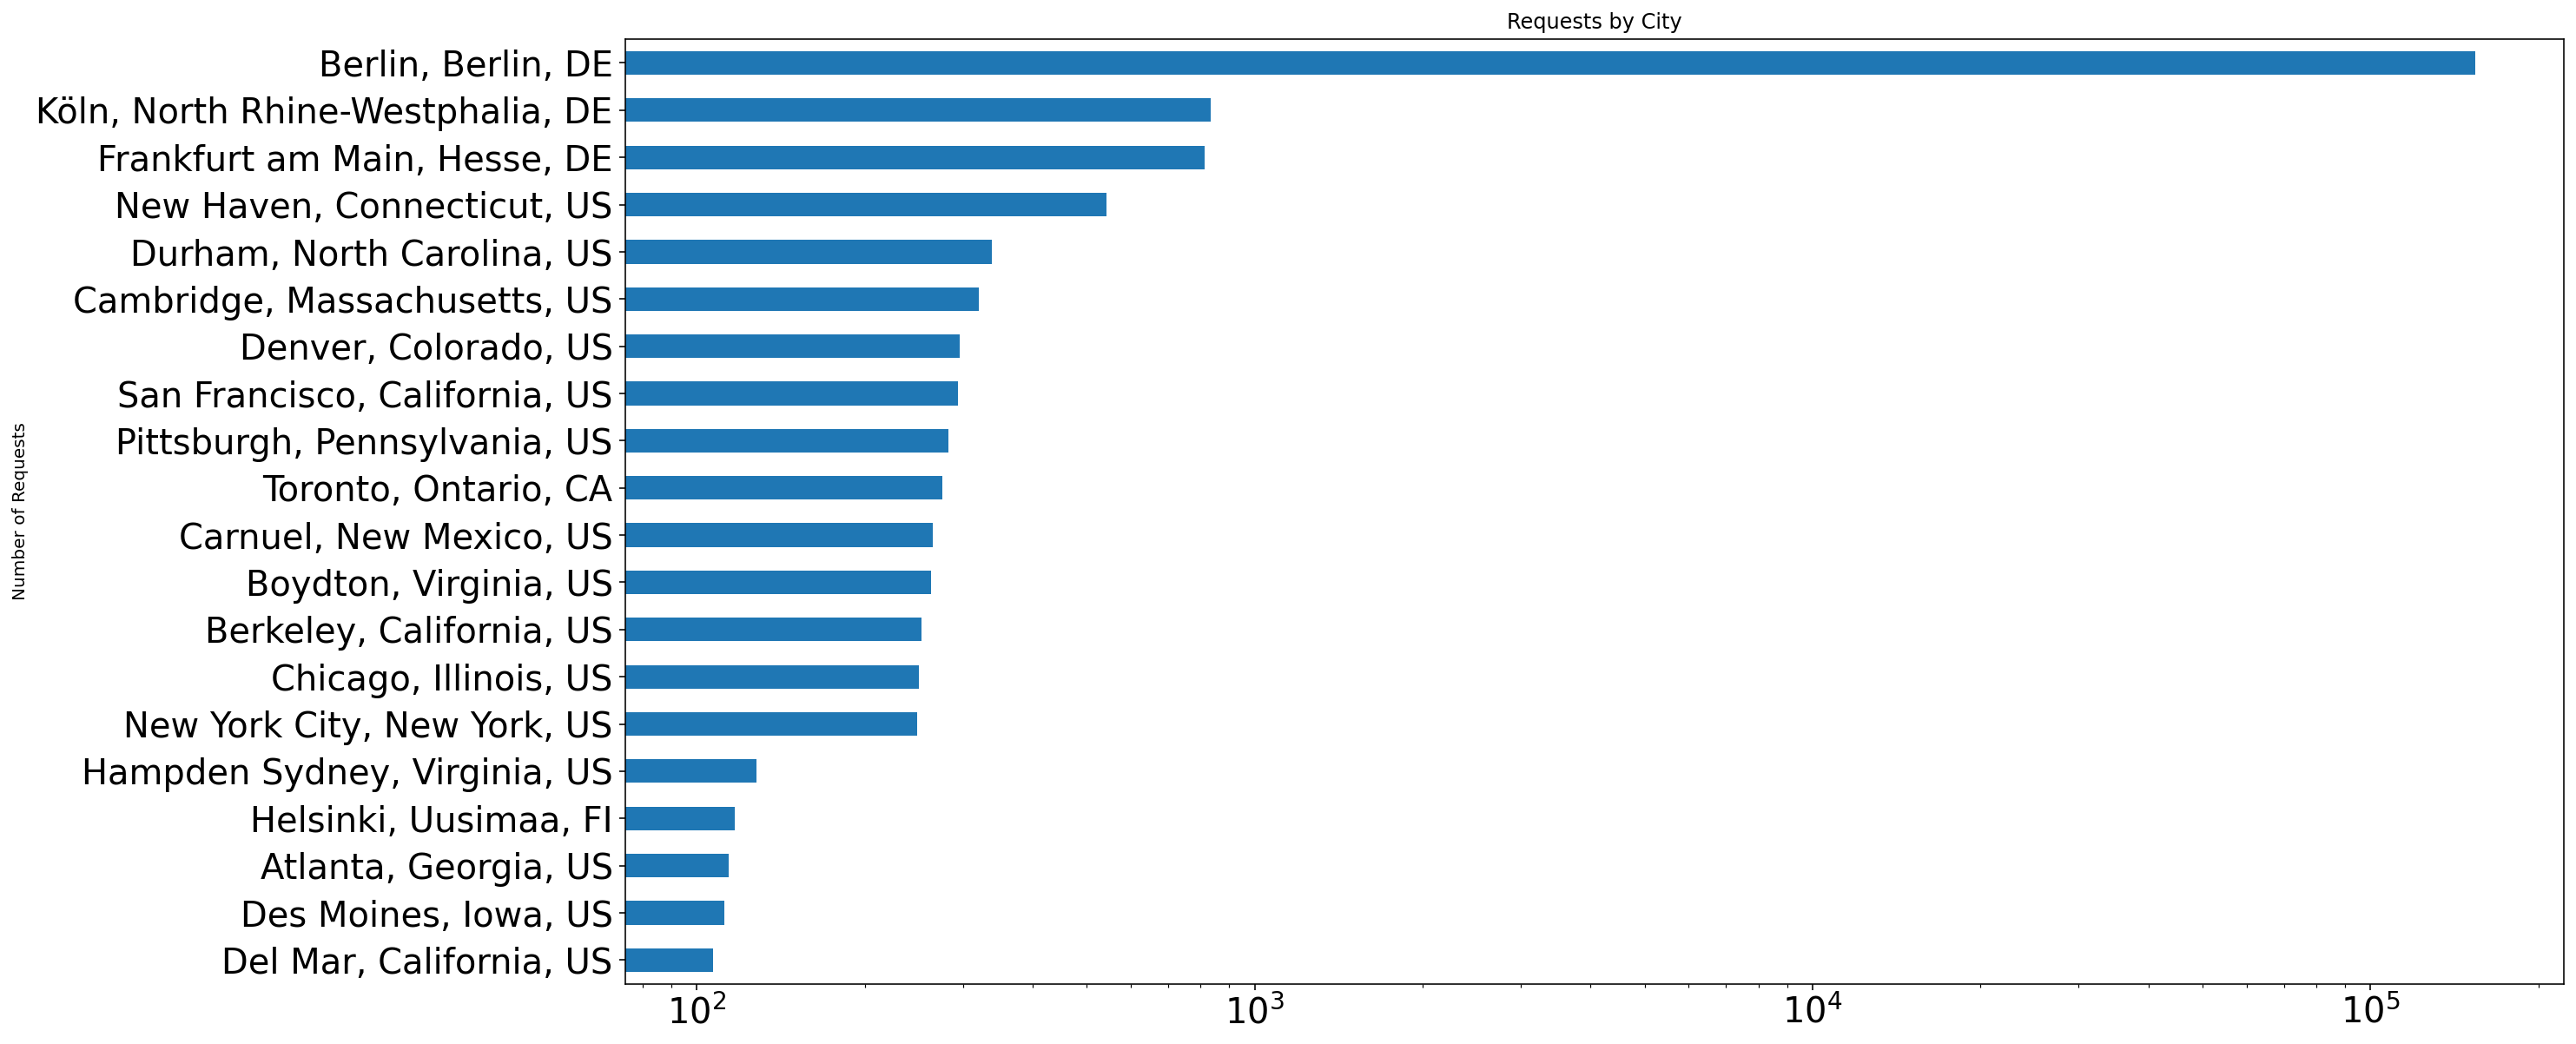

In [8]:
top_n = 20

full_location = logs.remote_ip_city + ", " + logs.remote_ip_region + ", " + logs.remote_ip_country

full_location.value_counts().head(top_n).sort_values().plot.barh(figsize=(20,10), fontsize=20, ylabel="Number of Requests", title="Requests by City", logx=True)

## Top referers

In [33]:
logs.referer.isna().value_counts()

True     161366
False      1570
Name: referer, dtype: int64

Most referers are null.

<AxesSubplot:title={'center':'Top Referers'}, ylabel='Number of Referals'>

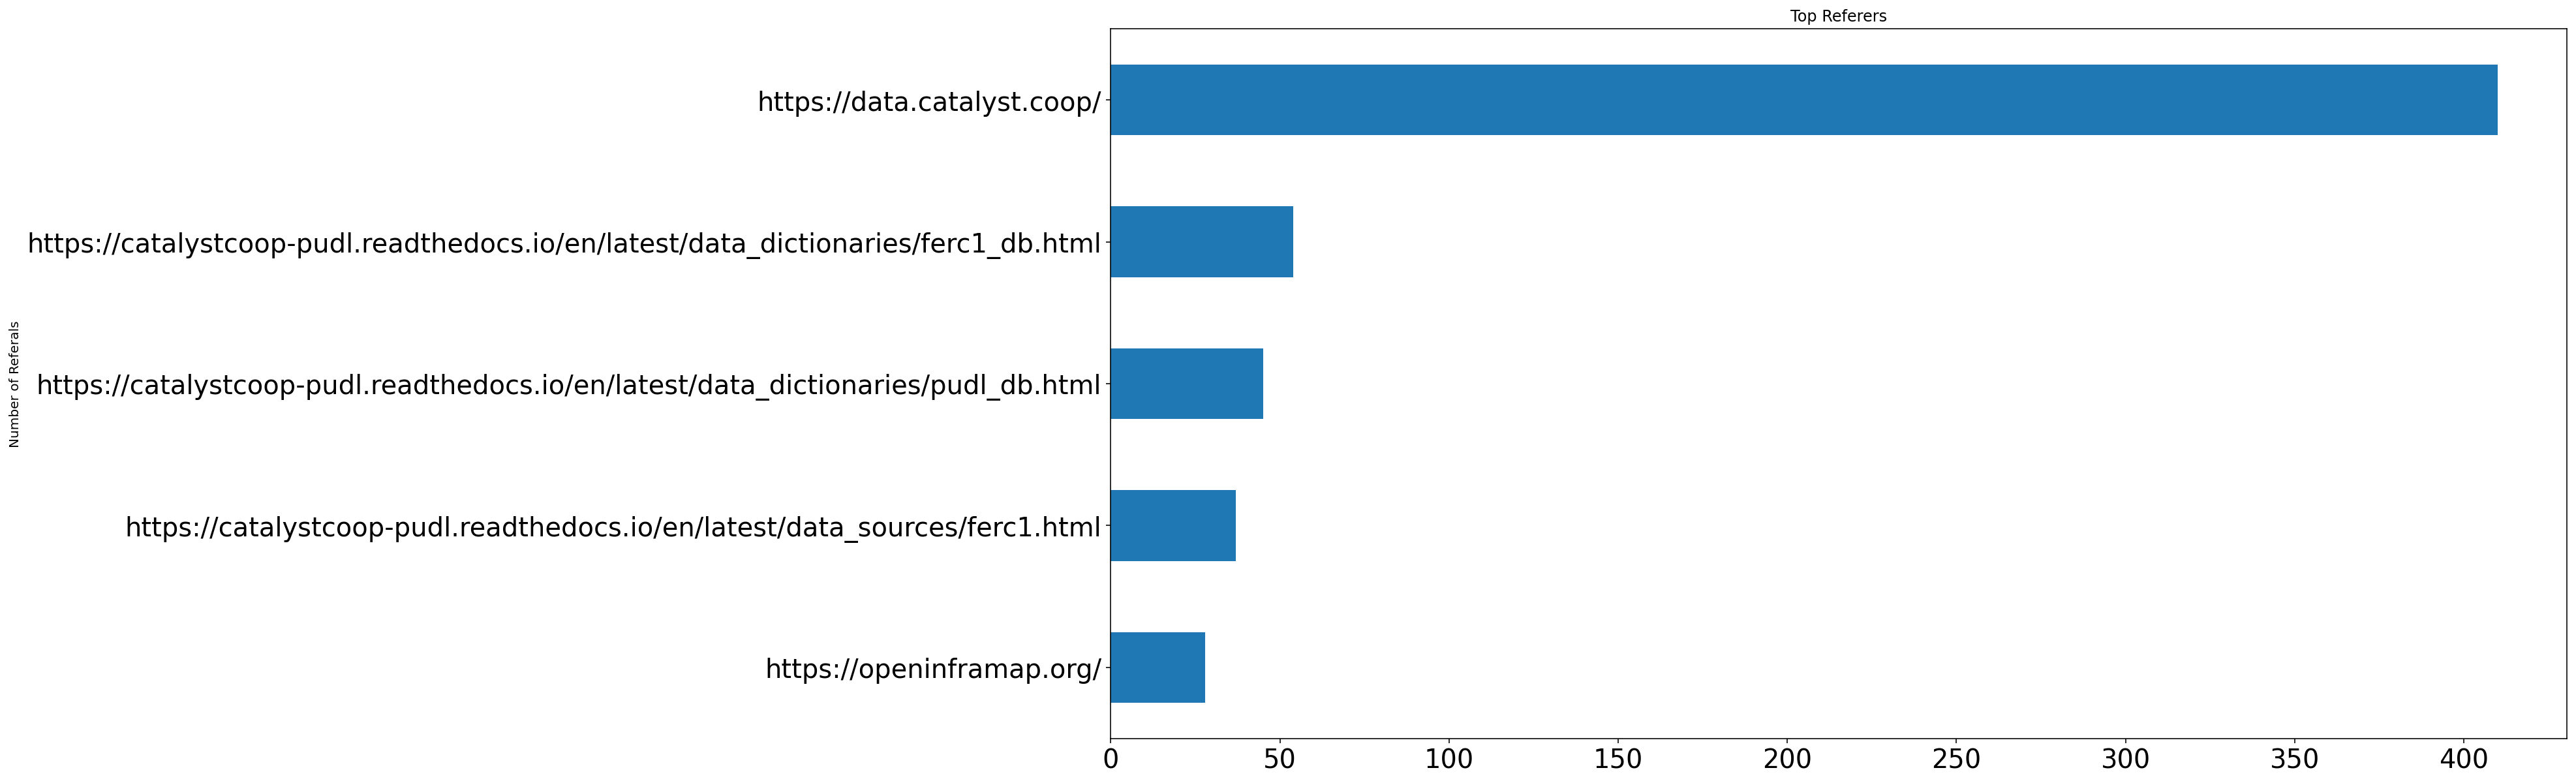

In [34]:
top_n = 5

logs.referer.value_counts().head(top_n).sort_values().plot.barh(figsize=(20,10), fontsize=20, ylabel="Number of Referals", title="Top Referers")